In [1]:
import numpy as np
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt
import japanize_matplotlib
%matplotlib inline
import seaborn as sns

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset, Dataset
# 評価関数
from sklearn.metrics import mean_squared_error as MSE

# 訓練データの読み込み

In [115]:
class TrainDataset(Dataset):
    def __init__(self):        
        super().__init__()
        
        # 学習データ
        data = pd.read_csv('train.csv')
        data_add = pd.read_csv('train_add.csv')
        data_new = pd.concat([data, data_add])
        
        # スタジアム
        stadium = pd.read_csv('stadium.csv')
        data_all = pd.merge(data_new, stadium, left_on='stadium', right_on='name', how='left') 
        
        # data_allのnameカラムを削除して、data_allに代入してください。
        data_all = data_all.drop(columns=['name'])
        
        # 不正データの補正 (レコード削除のパターンもあるため、ファイル読み込み直後に処理する)
        self.df = self.correction(data_all.copy())
        
        # 目的変数の外れ値は、評価データに存在しないため、init内で処理する
        self.df = self.df[self.df['y'] > 0]
        tmp = self.df['y'] / self.df['capa']
        self.df['y_capa'] = tmp.round(5)
        
        # 説明変数と目的変数に分割する
        df_x = self.df.drop(['y', 'y_capa'], axis=1)
        self.df_y = self.df.loc[:,['y']]
        self.df_y_capa = self.df.loc[:,['y_capa']]
        
        
        # 説明変数の量的データ、質的データ分割
        self.x_cate , self.x_cont, self.x_id = self.DataChange(df_x.copy())
        self.x_desc = self.x_cont.describe()
        
        self.x_cate_conv = self.x_cate.copy()
        self.x_cont_conv = self.x_cont.copy()
        
        self.DataConv()
        
        print(self.x_cate_conv.info())
        print(self.x_cont_conv.info())
        
        self.num = len(self.X_train_cate)
    
    def __getitem__(self, index):
        return self.X_train_cate[index], self.X_train_cont[index], self.Y_train_capa[index]
    
    def __len__(self):
        return self.num
    
    
    def correction(self, df):

        df['month'] = df['gameday'].apply(self.get_month)
        df['week'] = df['gameday'].apply(self.get_week)
        df['match_num'] = df['match'].apply(self.get_match)
        df['hour'] = df['time'].apply(self.get_hour)
        df['tv_num'] = df['tv'].apply(self.get_num)
        df = df.replace('ザスパ草津','ザスパクサツ群馬')
        df = df.replace('岐阜メモリアルセンター長良川球技メドウ','岐阜メモリアルセンター長良川競技場')
        
        #print('null check')
        #print(df.isnull().sum())
        #print('-------------------------')
        
        return df
    
    def DataChange(self, df_x):
        categ_cols = ['year', 'stage' , 'match', 'match_num' ,'gameday', 'time', 'home' ,'away', 'tv' , 'month' , 'week' ]
        contin_cols = [ 'tv_num']
        index_cols = ['id', 'capa']

        ####################################
        ##  データ分割
        ##  説明変数と目的変数に分ける。
        ##  説明変数はカテゴリデータと連続データに分ける。
        ####################################
        x_cate = df_x[categ_cols].copy()
        x_cont = df_x[contin_cols].copy()
        x_id = df_x[index_cols].copy()
        x_id = x_id.astype('int64')
        
        return x_cate , x_cont  ,x_id
    
    
    # 開催日の月を取り出す
    def get_month(self, x):
        return int(x[0:2])
    
    # 開催日の曜日を取り出す
    def get_week(self, x):
        return x[6:7]
    
    # 開催日の月を取り出す
    def get_hour(self, x):
        return int(x[0:2])
    
    # 第〇節の値を取り出して数値化する
    def get_match(self, x):
        return int(x[x.find('第') + 1: x.find('節')])
    
    # 湿度を数値化する
    def get_humidity(self, x):
        return float(x[:-1])/100
    
    # 放送するテレビ局の数を数える
    def get_num(self, x):
        return len(x.split('／'))

    def dropCol(self):
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=['year', 'gameday', 'tv' ,'match', 'time', 'away' ], axis=1)
        
        
        #self.x_cont_conv = self.x_cont_conv.drop(columns=['year'], axis=1)
        
        
    def stageConv(self):
        
        col = 'stage'
        
        self.x_cate_conv[col + '_1'] = 0

        row_index = self.x_cate.index[self.x_cate[col]=='Ｊ１']        
        self.x_cate_conv.loc[row_index, col + '_1'] = 1
        
        # ALL ゼロがＪ２なので処理しない
        row_index = self.x_cate.index[self.x_cate[col]=='Ｊ２']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
        
        
    def monthConv(self):
        
        col = 'month'
        
        self.x_cate_conv[col + '_1'] = 0

        row_index = self.x_cate.index[self.x_cate[col]=='12']
        self.x_cate_conv.loc[row_index, col + '_1'] = 1
        
        # 12月だけ観客数が多いので、その他は０にする
        row_index = self.x_cate.index[self.x_cate[col]=='03']
        row_index = self.x_cate.index[self.x_cate[col]=='04']
        row_index = self.x_cate.index[self.x_cate[col]=='05']
        row_index = self.x_cate.index[self.x_cate[col]=='06']
        row_index = self.x_cate.index[self.x_cate[col]=='07']
        row_index = self.x_cate.index[self.x_cate[col]=='08']
        row_index = self.x_cate.index[self.x_cate[col]=='09']
        row_index = self.x_cate.index[self.x_cate[col]=='10']
        row_index = self.x_cate.index[self.x_cate[col]=='11']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
    
    def weekConv(self):
        
        col = 'week'
        
        self.x_cate_conv[col + '_1'] = 0

        row_index = self.x_cate.index[self.x_cate[col]=='土']
        self.x_cate_conv.loc[row_index, col + '_1'] = 1
        
        # 土曜日だけ観客数が多いので、その他は０にする
        row_index = self.x_cate.index[self.x_cate[col]=='日']
        row_index = self.x_cate.index[self.x_cate[col]=='月']
        row_index = self.x_cate.index[self.x_cate[col]=='火']
        row_index = self.x_cate.index[self.x_cate[col]=='水']
        row_index = self.x_cate.index[self.x_cate[col]=='木']
        row_index = self.x_cate.index[self.x_cate[col]=='金']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
    
    def homeConv(self):
        
        col = 'home'
        
        self.x_cate_conv[col + '_01'] = 0
        self.x_cate_conv[col + '_02'] = 0
        self.x_cate_conv[col + '_03'] = 0
        self.x_cate_conv[col + '_04'] = 0
        self.x_cate_conv[col + '_05'] = 0
        
        self.x_cate_conv[col + '_06'] = 0
        self.x_cate_conv[col + '_07'] = 0
        self.x_cate_conv[col + '_08'] = 0
        self.x_cate_conv[col + '_09'] = 0
        self.x_cate_conv[col + '_10'] = 0
        
        self.x_cate_conv[col + '_11'] = 0
        self.x_cate_conv[col + '_12'] = 0
        self.x_cate_conv[col + '_13'] = 0
        self.x_cate_conv[col + '_14'] = 0
        self.x_cate_conv[col + '_15'] = 0
        
        self.x_cate_conv[col + '_16'] = 0
        self.x_cate_conv[col + '_17'] = 0
        self.x_cate_conv[col + '_18'] = 0
        self.x_cate_conv[col + '_19'] = 0
        self.x_cate_conv[col + '_20'] = 0
        
        self.x_cate_conv[col + '_21'] = 0
        self.x_cate_conv[col + '_22'] = 0
        self.x_cate_conv[col + '_23'] = 0
        self.x_cate_conv[col + '_24'] = 0
        self.x_cate_conv[col + '_25'] = 0
        
        self.x_cate_conv[col + '_26'] = 0
        self.x_cate_conv[col + '_27'] = 0
        self.x_cate_conv[col + '_28'] = 0
        self.x_cate_conv[col + '_29'] = 0
        self.x_cate_conv[col + '_30'] = 0
        
        self.x_cate_conv[col + '_31'] = 0
        self.x_cate_conv[col + '_32'] = 0
        self.x_cate_conv[col + '_33'] = 0
        self.x_cate_conv[col + '_34'] = 0
        #self.x_cate_conv[col + '_35'] = 0
        
        #self.x_cate_conv[col + '_36'] = 0
        #self.x_cate_conv[col + '_37'] = 0
        #self.x_cate_conv[col + '_38'] = 0
        #self.x_cate_conv[col + '_39'] = 0
        #self.x_cate_conv[col + '_40'] = 0
        
        #self.x_cate_conv[col + '_41'] = 0
        #self.x_cate_conv[col + '_42'] = 0
        
        row_index = self.x_cate[(self.x_cate[col]=='ベガルタ仙台') & (self.x_cate['year'] == 2012)].index
        self.x_cate_conv.loc[row_index, col + '_01'] = 1        
        row_index = self.x_cate[(self.x_cate[col]=='ベガルタ仙台') & ~(self.x_cate['year'] == 2012)].index
        self.x_cate_conv.loc[row_index, col + '_02'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='セレッソ大阪') & (self.x_cate['year'] == 2012)].index
        self.x_cate_conv.loc[row_index, col + '_03'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='セレッソ大阪') & (self.x_cate['year'] == 2013)].index
        self.x_cate_conv.loc[row_index, col + '_04'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='セレッソ大阪') & (self.x_cate['year'] == 2014)].index                
        self.x_cate_conv.loc[row_index, col + '_05'] = 1
        
        
        row_index = self.x_cate.index[self.x_cate[col]=='浦和レッズ']
        self.x_cate_conv.loc[row_index, col + '_06'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='清水エスパルス']
        self.x_cate_conv.loc[row_index, col + '_07'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ジュビロ磐田']
        self.x_cate_conv.loc[row_index, col + '_08'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='川崎フロンターレ']
        self.x_cate_conv.loc[row_index, col + '_09'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ヴァンフォーレ甲府']
        self.x_cate_conv.loc[row_index, col + '_10'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='湘南ベルマーレ']
        self.x_cate_conv.loc[row_index, col + '_11'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='名古屋グランパス']
        self.x_cate_conv.loc[row_index, col + '_12'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='松本山雅ＦＣ']
        self.x_cate_conv.loc[row_index, col + '_13'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='サガン鳥栖']
        self.x_cate_conv.loc[row_index, col + '_14'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='大宮アルディージャ']
        self.x_cate_conv.loc[row_index, col + '_15'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='ジェフユナイテッド千葉']
        self.x_cate_conv.loc[row_index, col + '_16'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='アルビレックス新潟']
        self.x_cate_conv.loc[row_index, col + '_17'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='横浜ＦＣ']
        self.x_cate_conv.loc[row_index, col + '_18'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ＦＣ岐阜']
        self.x_cate_conv.loc[row_index, col + '_19'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ロアッソ熊本']
        self.x_cate_conv.loc[row_index, col + '_20'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='京都サンガF.C.']
        self.x_cate_conv.loc[row_index, col + '_21'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='横浜Ｆ・マリノス') & (self.x_cate['year'] == 2012)].index
        self.x_cate_conv.loc[row_index, col + '_22'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='横浜Ｆ・マリノス') & ~(self.x_cate['year'] == 2012)].index
        self.x_cate_conv.loc[row_index, col + '_23'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='徳島ヴォルティス') & (self.x_cate['year'] == 2014)].index
        self.x_cate_conv.loc[row_index, col + '_24'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='徳島ヴォルティス') & ~(self.x_cate['year'] == 2014)].index
        self.x_cate_conv.loc[row_index, col + '_25'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='ＦＣ東京']
        self.x_cate_conv.loc[row_index, col + '_26'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ファジアーノ岡山']
        self.x_cate_conv.loc[row_index, col + '_27'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='鹿島アントラーズ']
        self.x_cate_conv.loc[row_index, col + '_28'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='']
        row_index = self.x_cate[(self.x_cate[col]=='ヴィッセル神戸') & (self.x_cate['year'] == 2013)].index
        self.x_cate_conv.loc[row_index, col + '_29'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='ヴィッセル神戸') & ~(self.x_cate['year'] == 2013)].index
        self.x_cate_conv.loc[row_index, col + '_30'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='柏レイソル']
        self.x_cate_conv.loc[row_index, col + '_31'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='ガンバ大阪') & (self.x_cate['year'] == 2012)].index
        self.x_cate_conv.loc[row_index, col + '_32'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='ガンバ大阪') & (self.x_cate['year'] == 2013)].index
        self.x_cate_conv.loc[row_index, col + '_33'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='ガンバ大阪') & (self.x_cate['year'] == 2014)].index
        self.x_cate_conv.loc[row_index, col + '_34'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='水戸ホーリーホック']
        row_index = self.x_cate.index[self.x_cate[col]=='コンサドーレ札幌']
        row_index = self.x_cate.index[self.x_cate[col]=='Ｖ・ファーレン長崎']
        row_index = self.x_cate.index[self.x_cate[col]=='サンフレッチェ広島']
        row_index = self.x_cate.index[self.x_cate[col]=='大分トリニータ']
        row_index = self.x_cate.index[self.x_cate[col]=='東京ヴェルディ']
        row_index = self.x_cate.index[self.x_cate[col]=='アビスパ福岡']
        row_index = self.x_cate.index[self.x_cate[col]=='愛媛ＦＣ']
        row_index = self.x_cate.index[self.x_cate[col]=='ギラヴァンツ北九州']
        row_index = self.x_cate.index[self.x_cate[col]=='栃木ＳＣ']
        row_index = self.x_cate.index[self.x_cate[col]=='ＦＣ町田ゼルビア']
        row_index = self.x_cate.index[self.x_cate[col]=='ザスパクサツ群馬']        
        row_index = self.x_cate.index[self.x_cate[col]=='モンテディオ山形']
        row_index = self.x_cate.index[self.x_cate[col]=='ガイナーレ鳥取']
        row_index = self.x_cate.index[self.x_cate[col]=='カターレ富山']
        row_index = self.x_cate.index[self.x_cate[col]=='カマタマーレ讃岐']     
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)

    def mutchCol(self):
        
        col = 'match_num'
        
        self.x_cate_conv[col + '_01'] = 0
        self.x_cate_conv[col + '_02'] = 0
        self.x_cate_conv[col + '_03'] = 0
        self.x_cate_conv[col + '_04'] = 0
        self.x_cate_conv[col + '_05'] = 0
        
        #self.x_cate_conv[col + '_06'] = 0
        #self.x_cate_conv[col + '_07'] = 0
        #self.x_cate_conv[col + '_08'] = 0
        #self.x_cate_conv[col + '_09'] = 0
        #self.x_cate_conv[col + '_10'] = 0
        

        row_index = self.x_cate[(self.x_cate[col]==1)].index
        self.x_cate_conv.loc[row_index, col + '_01'] = 1   
        row_index = self.x_cate[(self.x_cate[col]==2)].index
        self.x_cate_conv.loc[row_index, col + '_01'] = 1 
        

        rrow_index = self.x_cate[(self.x_cate[col]==11) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_02'] = 1
        rrow_index = self.x_cate[(self.x_cate[col]==12) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_02'] = 1
        rrow_index = self.x_cate[(self.x_cate[col]==13) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_02'] = 1
        
        
        rrow_index = self.x_cate[(self.x_cate[col]==20) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_03'] = 1
        rrow_index = self.x_cate[(self.x_cate[col]==21) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_03'] = 1
        rrow_index = self.x_cate[(self.x_cate[col]==22) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_03'] = 1
        
        rrow_index = self.x_cate[(self.x_cate[col]==33) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_04'] = 1
        rrow_index = self.x_cate[(self.x_cate[col]==34) & (self.x_cate['stage'] == 'Ｊ１')].index
        self.x_cate_conv.loc[row_index, col + '_04'] = 1
        
        rrow_index = self.x_cate[(self.x_cate[col]==41) & (self.x_cate['stage'] == 'Ｊ２')].index
        self.x_cate_conv.loc[row_index, col + '_05'] = 1
        rrow_index = self.x_cate[(self.x_cate[col]==42) & (self.x_cate['stage'] == 'Ｊ２')].index
        self.x_cate_conv.loc[row_index, col + '_05'] = 1
        
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
        
    def addCol(self):
        
        col = 'special'
        
        
        self.x_cate_conv['tokusima'] = 0
        self.x_cate_conv['tokusima'][(self.x_cate_conv['away'] == '徳島ヴォルティス') & (self.x_cate['year'] == 2014)] = 1
        
        
        
    
    def train_Split(self):
        
        # 訓練データと検証データに分割
        x_train_cate, x_test_cate ,y_train, y_test = train_test_split(self.x_cate_conv, self.df_y, test_size=0.2, random_state=3) 
        
        # カテゴリデータと同じ行数分数値データを抽出する (id も訓練データと検証データに分ける)
        ### 訓練データ
        row_index = x_train_cate.index.values
        x_train_cont = self.x_cont_conv.loc[row_index, :]
        self.X_train_id = self.x_id.loc[row_index, :]
        self.X_train_id.reset_index(drop=True, inplace=True)
        y_train_capa = self.df_y_capa.loc[row_index, :]
        
        ###　検証データ
        row_index = x_test_cate.index.values
        x_test_cont = self.x_cont_conv.loc[row_index, :]
        self.X_test_id = self.x_id.loc[row_index, :]
        self.X_test_id.reset_index(drop=True, inplace=True)
        y_test_capa = self.df_y_capa.loc[row_index, :]
        
        
        x_train_cate = np.array(x_train_cate, dtype=np.float64)
        x_test_cate = np.array(x_test_cate, dtype=np.float64)
        x_train_cont = np.array(x_train_cont, dtype=np.float64)
        x_test_cont = np.array(x_test_cont, dtype=np.float64)
        y_train = np.array(y_train, dtype=np.float64)
        y_test = np.array(y_test, dtype=np.float64)
        y_train_capa = np.array(y_train_capa, dtype=np.float64)
        y_test_capa = np.array(y_test_capa, dtype=np.float64)
        
        
        # numpy の値を torch の値に変換する
        self.X_train_cate = torch.from_numpy(x_train_cate).float()
        self.X_train_cont = torch.from_numpy(x_train_cont).float()
        self.Y_train = torch.from_numpy(y_train).float()
        self.Y_train_capa = torch.from_numpy(y_train_capa).float()
        
        self.X_test_cate = torch.from_numpy(x_test_cate).float()
        self.X_test_cont = torch.from_numpy(x_test_cont).float()
        self.Y_test = torch.from_numpy(y_test).float()
        self.Y_test_capa = torch.from_numpy(y_test_capa).float()
        
        # 列数
        self.coti_size = self.X_train_cont.shape[1]
        self.cate_size  = self.X_train_cate.shape[1]
        self.in_size  = self.coti_size + self.cate_size
        self.out_size = self.Y_train.shape[1]  
        
    
    def DataConv(self):
        self.addCol()
        self.mutchCol()
        self.stageConv()
        
        self.monthConv()
        self.weekConv()
        self.homeConv()
        
        self.dropCol()        
        self.train_Split()
        

In [116]:
train_dataset = TrainDataset()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 0 to 1952
Data columns (total 41 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   tokusima      1952 non-null   int64
 1   match_num_01  1952 non-null   int64
 2   match_num_02  1952 non-null   int64
 3   match_num_03  1952 non-null   int64
 4   match_num_04  1952 non-null   int64
 5   match_num_05  1952 non-null   int64
 6   stage_1       1952 non-null   int64
 7   month_1       1952 non-null   int64
 8   week_1        1952 non-null   int64
 9   home_01       1952 non-null   int64
 10  home_02       1952 non-null   int64
 11  home_03       1952 non-null   int64
 12  home_04       1952 non-null   int64
 13  home_05       1952 non-null   int64
 14  home_06       1952 non-null   int64
 15  home_07       1952 non-null   int64
 16  home_08       1952 non-null   int64
 17  home_09       1952 non-null   int64
 18  home_10       1952 non-null   int64
 19  home_11       1952 non-null

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\ipykernel_launcher.py:377: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [117]:
train_dataset.in_size

42

In [118]:
train_dataset.out_size

1

In [119]:
len(train_dataset)

1561

In [120]:
train_dataset.x_cate_conv

,tokusima,match_num_01,match_num_02,match_num_03,match_num_04,match_num_05,stage_1,month_1,week_1,home_01,...,home_23,home_24,home_25,home_26,home_27,home_28,home_29,home_30,home_31,home_32
0,0,1,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1949,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1950,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
train_dataset.x_cont_conv

,tv_num
0,4
1,4
2,4
3,4
4,4
...,...
1948,2
1949,2
1950,2
1951,2


# 評価データの読み込み

In [122]:
class TestDataset(TrainDataset):
    def __init__(self, x_desc):
        # 学習データ
        data = pd.read_csv('test.csv')

        # スタジアム
        self.stadium = pd.read_csv('stadium.csv')
        data_all = pd.merge(data, self.stadium, left_on='stadium', right_on='name', how='left') 
        
        # data_allのnameカラムを削除して、data_allに代入してください。
        data_all = data_all.drop(columns=['name'])
        
        # 不正データの補正 (レコード削除のパターンもあるため、ファイル読み込み直後に処理する)
        data_all = self.correction(data_all.copy())
        
        # 目的変数の格納
        self.x_cate , self.x_cont, self.x_id = self.DataChange(data_all.copy())
        self.x_desc = x_desc
        
        self.x_cate_conv = self.x_cate.copy()
        self.x_cont_conv = self.x_cont.copy()
        
        # データの加工（標準化や対数化など）
        #self.std_scale = 0
        self.max_scale = 0
        #self.dobule_scale = 0
        #self.polynomialFlg = 0
        #self.binSplitFlg = 0
        #self.logFlg  = 0
        self.DataConv()
        
        #self.NpToPy()
        #self.num = len(self.x_cate)
        self.num = len(self.x_cate_conv)
        self.coti_size = self.x_cont_conv.shape[1]

    def __getitem__(self, index):
        return self.X_vat[index]
    
    def __len__(self):
        return self.num
    
    def train_Split(self):
        
        #x_temp = self.x_cont.copy()
        tmp_cate = np.array(self.x_cate_conv)
        tmp_cont = np.array(self.x_cont_conv)
        
        # numpy の値を torch の値に変換する
        self.X_vat_cate = torch.from_numpy(tmp_cate).float()
        self.X_vat_cont = torch.from_numpy(tmp_cont).float()
 

In [123]:
test_dataset = TestDataset(train_dataset.x_desc)

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\ipykernel_launcher.py:377: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


# モデル定義

In [124]:
batchsize=100

# batch_size ：学習する時にまとめるデータ数
# shuffle    : データをランダムに並び替える場合はTrue
#train_loader = DataLoader(train ,batch_size=30, shuffle=True, num_workers=2)
train_loader = DataLoader(dataset=train_dataset ,batch_size=batchsize, shuffle=True)

In [125]:
node1=60
node2=30


# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net1(nn.Module):
    # 初期化の関数
    def __init__(self):
        super(Net1 ,self).__init__()
        # ドロップアウト
        p=0.5
        self.dropout1 = nn.Dropout(p)
        self.dropout2 = nn.Dropout(p)
        
        # バッチ正規化
        self.bn_cont = nn.BatchNorm1d(train_dataset.coti_size)
        
        # 全結合層
        self.fc1 = nn.Linear(train_dataset.in_size , node1)         # nn.Linear (入力のノード数 , 中間層ノード数)
        self.fc2 = nn.Linear(node1 , node2)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc3 = nn.Linear(node2,  train_dataset.out_size)        # nn.Linear (中間層ノード数 , 出力のノード数)
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x_cate, x_cont):

        # バッチ正規化
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x_cate, x_cont], 1)
        
        x = torch.relu(self.fc1(x))           # 入力のノードを中間層（１階層目）に渡して結果を得る
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))           # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))           # 中間層（２階層目）の結果を出力層に渡す
        return x

In [126]:
# モデルの定義
model1 = Net1()
# 損失の定義
criterion1 = nn.MSELoss()
# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）
optimizer1 = optim.Adam(model1.parameters() , lr=0.01)

In [127]:
loss_list1 = []
accuracy_list1 = []

correct_counter1 = 0
logdisp=1
#acccnt=len(train_dataset)*logdisp
acccnt=batchsize*logdisp
print('rec_cnt', acccnt)
epochs=50
mathcnt = 0

# トレーニングの回数分ループする。
for epoch in range(epochs):
    # 損失を初期化　
    total_loss1 = 0
    
    for x_train_cate, x_train_cont, y_train in train_loader:
        
        
        # 出力を計算する 
        output1 = model1(x_train_cate, x_train_cont)
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss1 = criterion1(output1 ,y_train)
        
        correct_temp = np.sqrt(MSE(y_train.detach().numpy(), output1.detach().numpy()))
        correct_counter1 += correct_temp
        mathcnt += 1

        
        # パラメータの勾配を初期化する
        optimizer1.zero_grad()
        # ロスを伝播する
        loss1.backward()
        # パラメータを更新する
        optimizer1.step()

        # トータルロスを格納
        total_loss1 += loss1.item()

    
    # 回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_tmp1=total_loss1/acccnt
        print(f'Epoch\t{epoch+1}\tLoss\t{loss_tmp1:.8f}\tRMSE:\t{correct_counter1*100/mathcnt:.3f}')
        
        
        accuracy_list1.append(correct_counter1.item()*100/(mathcnt))
        loss_list1.append(loss_tmp1)
        total_loss=0
        correct_counter1 = 0
        mathcnt = 0
        

rec_cnt 100
Epoch	1	Loss	0.00827378	RMSE:	22.177
Epoch	2	Loss	0.00522681	RMSE:	18.007
Epoch	3	Loss	0.00478766	RMSE:	17.179
Epoch	4	Loss	0.00413765	RMSE:	16.032
Epoch	5	Loss	0.00400632	RMSE:	15.779
Epoch	6	Loss	0.00400797	RMSE:	15.757
Epoch	7	Loss	0.00386815	RMSE:	15.490
Epoch	8	Loss	0.00374361	RMSE:	15.268
Epoch	9	Loss	0.00372621	RMSE:	15.224
Epoch	10	Loss	0.00378955	RMSE:	15.348
Epoch	11	Loss	0.00370111	RMSE:	15.179
Epoch	12	Loss	0.00361602	RMSE:	14.938
Epoch	13	Loss	0.00359515	RMSE:	14.955
Epoch	14	Loss	0.00379874	RMSE:	15.362
Epoch	15	Loss	0.00378432	RMSE:	15.292
Epoch	16	Loss	0.00366454	RMSE:	15.035
Epoch	17	Loss	0.00353952	RMSE:	14.791
Epoch	18	Loss	0.00362423	RMSE:	14.995
Epoch	19	Loss	0.00363134	RMSE:	15.027
Epoch	20	Loss	0.00355978	RMSE:	14.867
Epoch	21	Loss	0.00365806	RMSE:	15.088
Epoch	22	Loss	0.00347606	RMSE:	14.671
Epoch	23	Loss	0.00343238	RMSE:	14.579
Epoch	24	Loss	0.00351389	RMSE:	14.771
Epoch	25	Loss	0.00358353	RMSE:	14.936
Epoch	26	Loss	0.00389571	RMSE:	15.558
Epoch	27	

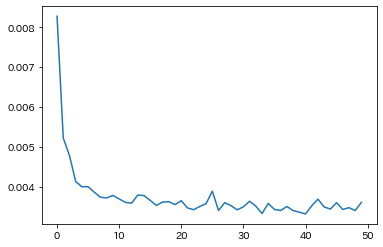

In [128]:
# ロスのプロット
plt.plot(loss_list1)

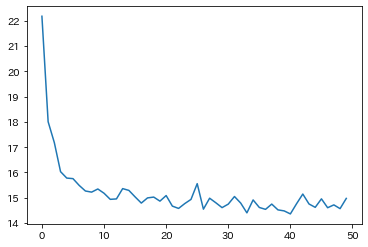

In [129]:
plt.plot(accuracy_list1)

# 予測

In [130]:
# 学習を行わないモードに変更
model1.eval()

Net1(
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=42, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=1, bias=True)
)

### 訓練データ

In [131]:
y_pred_train=model1(train_dataset.X_train_cate, train_dataset.X_train_cont).data
df_pred_train = pd.DataFrame(y_pred_train.numpy() , columns=['vat_tmp'])


# capa を結合して観客数を求める
df_pred_train = pd.concat([train_dataset.X_train_id , df_pred_train] , axis=1)
df_pred_train['vat'] = df_pred_train['vat_tmp'] * df_pred_train['capa']

y_pred_train = np.round(np.array(df_pred_train['vat']))
y_pred_train = y_pred_train.reshape(-1,1)



In [132]:
rmse_train = np.sqrt(MSE(train_dataset.Y_train, y_pred_train))
print(rmse_train)

4148.666447363516


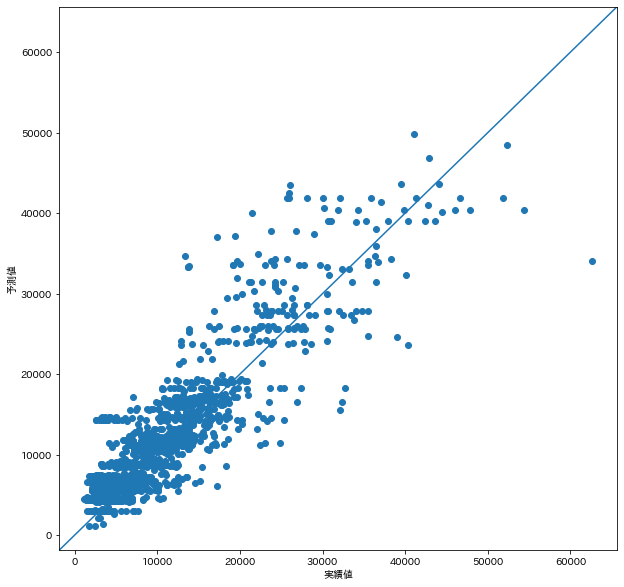

In [133]:
# 1.グラフのサイズを指定し、グラフの大きさを正方形になるように設定する
plt.figure(figsize=(10,10))

# 2.横軸を実測値、縦軸を予測値として、散布図を描く
plt.scatter(train_dataset.Y_train,y_pred_train)

# 値域を揃える為に、y_test、y_pred_testの両方を見た上での最小値と最大値を求める
min_value = min(min(train_dataset.Y_train.numpy()), min(y_pred_train)) - 3000
max_value = max(max(train_dataset.Y_train.numpy()), max(y_pred_train)) + 3000

# 3.最小値と最大値を使い、x軸およびy軸の値域を指定する
plt.xlim([min_value,max_value])
plt.ylim([min_value,max_value])

# 4.対角線を描く
plt.plot([min_value,max_value],[min_value,max_value])

#x軸とy軸に名前を付ける
plt.xlabel("実績値")
plt.ylabel("予測値")

# 可視化結果を表示する為に必要な関数
plt.show()

### 検証データ

In [134]:
y_pred_test=model1(train_dataset.X_test_cate, train_dataset.X_test_cont).data
df_pred_test = pd.DataFrame(y_pred_test.numpy() , columns=['vat_tmp'])

# capa を結合して観客数を求める
df_pred_test = pd.concat([train_dataset.X_test_id , df_pred_test] , axis=1)
df_pred_test['vat'] = df_pred_test['vat_tmp'] * df_pred_test['capa']

y_pred_test = np.round(np.array(df_pred_test['vat']))
y_pred_test = y_pred_test.reshape(-1,1)

In [135]:
rmse_test = np.sqrt(MSE(train_dataset.Y_test, y_pred_test))
print(rmse_test)

4377.758779730084


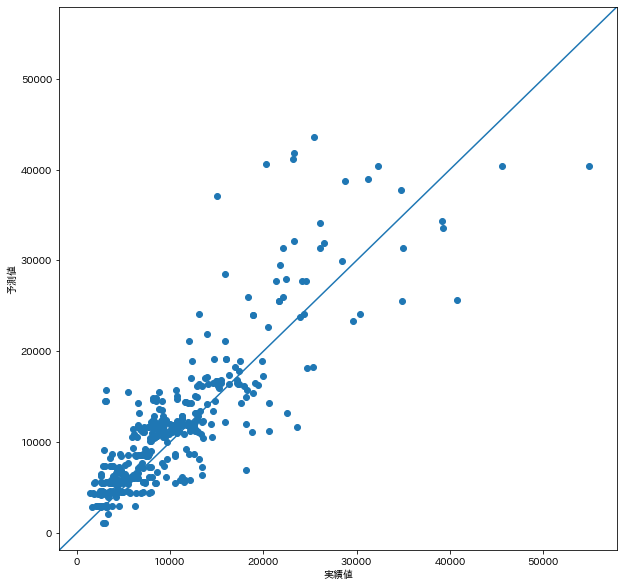

In [136]:
# 1.グラフのサイズを指定し、グラフの大きさを正方形になるように設定する
plt.figure(figsize=(10,10))

# 2.横軸を実測値、縦軸を予測値として、散布図を描く
plt.scatter(train_dataset.Y_test,y_pred_test)

# 値域を揃える為に、y_test、y_pred_testの両方を見た上での最小値と最大値を求める
min_value = min(min(train_dataset.Y_test.numpy()), min(y_pred_test)) - 3000
max_value = max(max(train_dataset.Y_test.numpy()), max(y_pred_test)) + 3000

# 3.最小値と最大値を使い、x軸およびy軸の値域を指定する
plt.xlim([min_value,max_value])
plt.ylim([min_value,max_value])

# 4.対角線を描く
plt.plot([min_value,max_value],[min_value,max_value])

#x軸とy軸に名前を付ける
plt.xlabel("実績値")
plt.ylabel("予測値")

# 可視化結果を表示する為に必要な関数
plt.show()

# 残差確認 

In [137]:

tmp = pd.concat([df_pred_train  ,df_pred_test] )
tmp = tmp.drop(columns=['capa', 'vat_tmp'] , axis=1)

data = pd.merge(train_dataset.df, tmp , on='id' , how='left')
data['res'] = data['y']  - data['vat']
data['res2'] = np.abs(data['res'])
data = data.sort_values(by = 'res2', ascending = False )

data.head(40)




,id,y,year,stage,match,gameday,time,home,away,stadium,...,capa,month,week,match_num,hour,tv_num,y_capa,vat,res,res2
1843,15127,62632,2013,Ｊ１,第３３節第１日,11/30(土),14:04,横浜Ｆ・マリノス,アルビレックス新潟,日産スタジアム,...,72327,11,土,33,14,3,0.86596,34079.709954,28552.290046,28552.290046
1806,14839,15051,2013,Ｊ１,第１節第１日,03/02(土),14:05,セレッソ大阪,アルビレックス新潟,ヤンマースタジアム長居,...,47816,3,土,1,14,4,0.31477,37072.846162,-22021.846162,22021.846162
721,14887,13384,2013,Ｊ１,第６節第１日,04/13(土),19:04,セレッソ大阪,大宮アルディージャ,ヤンマースタジアム長居,...,47816,4,土,6,19,3,0.27991,34617.169774,-21233.169774,21233.169774
1378,15691,20323,2014,Ｊ１,第３節第１日,03/15(土),15:04,セレッソ大阪,清水エスパルス,ヤンマースタジアム長居,...,47816,3,土,3,15,2,0.42503,40572.107493,-20249.107493,20249.107493
922,15113,17183,2013,Ｊ１,第３１節第１日,11/10(日),19:05,ベガルタ仙台,浦和レッズ,宮城スタジアム,...,49133,11,日,31,19,3,0.34972,37021.117325,-19838.117325,19838.117325
699,14859,13702,2013,Ｊ１,第３節第１日,03/16(土),15:04,セレッソ大阪,ＦＣ東京,ヤンマースタジアム長居,...,47816,3,土,3,15,2,0.28656,33337.494767,-19635.494767,19635.494767
1358,15669,13809,2014,Ｊ１,第１節第１日,03/01(土),14:05,ヴァンフォーレ甲府,鹿島アントラーズ,国立競技場,...,54224,3,土,1,14,4,0.25467,33433.353633,-19624.353633,19624.353633
1813,14864,13721,2013,Ｊ１,第４節第１日,03/30(土),13:04,セレッソ大阪,ベガルタ仙台,ヤンマースタジアム長居,...,47816,3,土,4,13,2,0.28695,33337.494767,-19616.494767,19616.494767
715,14880,23295,2013,Ｊ１,第５節第１日,04/06(土),19:04,浦和レッズ,ジュビロ磐田,埼玉スタジアム２００２,...,63700,4,土,5,19,4,0.36570,41844.244516,-18549.244516,18549.244516
844,15025,21420,2013,Ｊ１,第２２節第１日,08/24(土),18:04,清水エスパルス,浦和レッズ,エコパスタジアム,...,50889,8,土,22,18,2,0.42092,39955.209762,-18535.209762,18535.209762


# 評価データでの予測

In [140]:
y_pred_vat=model1(test_dataset.X_vat_cate, test_dataset.X_vat_cont).data
df_pred_vat = pd.DataFrame(y_pred_vat.numpy() , columns=['vat_tmp'])

# capa を結合して観客数を求める
df_pred_vat = pd.concat([test_dataset.x_id , df_pred_vat] , axis=1)
df_pred_vat['vat'] = df_pred_vat['vat_tmp'] * df_pred_vat['capa']

df_pred_vat = df_pred_vat.drop(columns=['capa', 'vat_tmp'])


print(df_pred_vat.head())

      id           vat
0  15822  16159.335820
1  15823  16508.115259
2  15824  41844.244516
3  15825  11900.358219
4  15827  27357.327211
